# Нейронные сети классификации изображений

# 6 Плотно связанные сети. DenseNet

Идеи ResNet по передаче информации между входом и выходом слоя, разложения функции преобразования на два слагаемых, может быть существенно расширена.

Почему бы не использовать на слое в качестве входов выходы **всех** предыдущих слоев?

ResNet блоки представляли функцию как два слагаемых $$f(\mathbf{x}) = \mathbf{x} + g(\mathbf{x}).$$

Но почему именно слагаемые? Ведь можно объединять результаты и другими способами. Например, контактенация.

Можно ввести следующую интерпретацию такого подхода.

Представьте что вы генеральный директор предприятия. Чтобы понять как успешно ваше предприятие ваши подчиненные, заместители, дают вам некоторые показатели, по ним вы и судите. Типичная классификация. Ваши замы получают показатели от своих подчиненных, обрабатывают их. А те от своих. Типичная последовательная сеть.

Но если вы вдруг перестали верить замам, хотите их проконтролировать, вдруг они врут, то на основе какой информации вы можете это сделать? Взять показатели зам-замов и их проанализировать. А если и тем не верите? Взять показатели у зам-зам-замов и так вплоть до рабочего. Это, конечно, потребует от вас неимоверных усилий, но зато вы сможете контролировать свое предприятие. Если замам можно верить, то на остальные показатели внимания и обращать не надо, пусть себе собираются. А вот если нельзя, то тут показатели всех предыдущих уровней ой как помогут.

Также и для классификатора, последние слои дают абстрактные признаки, и, возможно, их вполне хватит для хорошей классификации. Но ведь может и не хватить. Так используйте признаки предыдущих слоев. Чтоб не мелочиться - всех предыдущих слоев. Это касается не только последнего слоя, но и всех других, им может помочь информация о признаках на младших слоях.

Так устроена сеть DenseNet.

Вместо того чтобы складывать вход и выход блока, в DenseNet они контактенируются, причем от всех предыдущих слоев.

![img](https://d2l.ai/_images/densenet-block.svg) ![img](https://d2l.ai/_images/densenet.svg)

Получается сильно (плотно) разветвленная сеть.

$$\mathbf{x} \to \left[
\mathbf{x},
f_1(\mathbf{x}),
f_2([\mathbf{x}, f_1(\mathbf{x})]), f_3([\mathbf{x}, f_1(\mathbf{x}), f_2([\mathbf{x}, f_1(\mathbf{x})])]), \ldots\right].$$



Выделяют две части,
- плотные блоки *dense blocks*, которые определяют как именно входы и выходы объединяются,
- и передаточные слои *transition layers*, которые контролируют число каналов, ибо оно растет слишком быстро.


## Плотные блоки **Dense Blocks**

Эти блоки очень похожи на блоки ResNet, но только не складывают, а объединяют входы и выходы. Состоят из набора сверточных слоев, активаций, нормализаций.

Создадим такие блоки.


In [1]:
# установим вспомогательные функции из курса  d2l
!pip -q install d2l==0.17.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.2/83.2 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.4/123.4 kB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.5/93.5 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 57.0 MB/s eta 0:00:00


In [2]:
import tensorflow as tf
from d2l import tensorflow as d2l

# блоки сверток
class ConvBlock(tf.keras.layers.Layer):
    # инициализация
    def __init__(self, num_channels):
        super(ConvBlock, self).__init__()
        self.bn = tf.keras.layers.BatchNormalization() # нормализация
        self.relu = tf.keras.layers.ReLU() # активация
        self.conv = tf.keras.layers.Conv2D(
            filters=num_channels, kernel_size=(3, 3), padding='same') # свертка
        # список слоев
        self.listLayers = [self.bn, self.relu, self.conv]
    # расчет выхода
    def call(self, x): # принимаем вход
        y = x
        for layer in self.listLayers.layers: # пропускаем через слои
            y = layer(y)
        y = tf.keras.layers.concatenate([x,y], axis=-1) # объединяем вход и выход последнего слоя
        return y

Каждый плотный блок *dense block* состоит из сверточных блоков с одним и тем же числом каналов. Но при расчете выхода всего блока выходы сверточных блоков не складываются, а контактенируются по каналам.


In [3]:
# Плотный блок
class DenseBlock(tf.keras.layers.Layer):
    # инициализируем
    def __init__(self, num_convs, num_channels): # принимает число сверточных блоков и число каналов.
        super(DenseBlock, self).__init__()
        self.listLayers = [] # список всех сверточных блоков
        for _ in range(num_convs): # по числу сверточных блоков
            self.listLayers.append(ConvBlock(num_channels)) # добавляем сверточный блок
    # расчет выхода
    def call(self, x):
        for layer in self.listLayers.layers:
            x = layer(x)
        return x

Для примера определим `DenseBlock` с 2 сверточными блоками по 10 каналов.

Для входа с 3 каналами получим выход блока с  $3+2\times 10=23$ каналами. Количество сверточных слоев в блоке определяет во сколько раз увеличится число каналов на выходе блока, такое число можно назвать *коэффициентом разрастания*.


In [4]:
blk = DenseBlock(2, 10)
X = tf.random.uniform((4, 8, 8, 3))
Y = blk(X)
Y.shape

TensorShape([4, 8, 8, 23])

## Передаточные слои **Transition Layers**

В каждом плотном блоке число каналов будет возрастать очень сильно. Используем передаточные слои *transition layer*, чтобы контроллировать число каналов. Такие слои будут использовать свертку с ядром $1\times 1$, уменьшать пространственные размеры в два раза с помощью слоя AvgPool2D со сдвигом 2, ну и пусть будет еще и нормализация.

Обратите внимание, AvgPool2D это слой по аналогии с maxpooling, но только выбирает не максимальный элемент, а находит среднее значение. Он отличается от GlobalAvgPool2D.    


In [5]:
# Передаточный слой
class TransitionBlock(tf.keras.layers.Layer):
    # инициализируем
    def __init__(self, num_channels, **kwargs): # принимает число каналов выхода и прочие параметры
        super(TransitionBlock, self).__init__(**kwargs)
        self.batch_norm = tf.keras.layers.BatchNormalization() # нормализация
        self.relu = tf.keras.layers.ReLU() # активация
        self.conv = tf.keras.layers.Conv2D(num_channels, kernel_size=1) # свертка 1х1
        self.avg_pool = tf.keras.layers.AvgPool2D(pool_size=2, strides=2)# усреднение
    # расчет выхода
    def call(self, x):
        x = self.batch_norm(x) # нормализуем
        x = self.relu(x) # активация
        x = self.conv(x) # свертка
        return self.avg_pool(x) # усреднение

Для примера применим его к выходу плотного блока, определенного выше, зададим 10 каналов. В результате эти 10 каналов и получим на выходе, пространственная размерность уменьшится в два раза.


In [6]:
blk = TransitionBlock(10)
blk(Y).shape

TensorShape([4, 4, 4, 10])

## Сеть DenseNet
Наконец, создадим сеть DenseNet.
Первая часть использует такую же свертку и пулинг, как и в ResNet.


In [7]:
# Начало сети
def block_1():
    return tf.keras.Sequential([
       tf.keras.layers.Conv2D(64, kernel_size=7, strides=2, padding='same'), # свертка
       tf.keras.layers.BatchNormalization(), # нормализация
       tf.keras.layers.ReLU(), # активация
       tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same')]) # субдискретизация

Вместо 4 частей ResNet используем 4 части из плотных блоков.

Здесь мы зададим по 4 сверточных слоя в блоке, чтоб походило на ResNet-18.

Количество каналов зададим  в 32, так что по 32*4=128 каналов будет добавляться в каждом плотном блоке.

Будем уменьшать пространственные размеры в два раза и число каналов также в два раза в передаточных слоях.



In [8]:
# Создаем блоки
def block_2():
    net = block_1() # начальная сеть
    num_channels = 64 # текущее число каналов
    growth_rate =  32 # количество каналов в блоке
    num_convs_in_dense_blocks = [4, 4, 4, 4] # число сверток в каждом блоке из четырех
    # в цикле по количеству блоков
    for i, num_convs in enumerate(num_convs_in_dense_blocks):
        net.add(DenseBlock(num_convs, growth_rate)) # добавляем плотный блок
        # число каналов на выходе предыдущего блока
        num_channels += num_convs * growth_rate
        # между плотными блоками добавляем передаточный слой
        if i != len(num_convs_in_dense_blocks) - 1:
            num_channels //= 2 # уменьшая число каналов в два раза.
            net.add(TransitionBlock(num_channels))
    return net

Как и в ResNet, добавляем global pooling layer и полносвязный слой классификации.


In [9]:
def net():
    net = block_2()
    net.add(tf.keras.layers.BatchNormalization())
    net.add(tf.keras.layers.ReLU())
    net.add(tf.keras.layers.GlobalAvgPool2D())
    net.add(tf.keras.layers.Flatten())
    net.add(tf.keras.layers.Dense(10))
    return net

In [10]:
input_shape=(None,224, 224, 3)
nn=net()
nn.build(input_shape)
nn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 112, 112, 64)      9472      
                                                                 
 batch_normalization_3 (Bat  (None, 112, 112, 64)      256       
 chNormalization)                                                
                                                                 
 re_lu_3 (ReLU)              (None, 112, 112, 64)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 56, 56, 64)        0         
 D)                                                              
                                                                 
 dense_block_1 (DenseBlock)  (None, 56, 56, 192)       130944    
                                                                 
 transition_block_1 (Transi  (None, 28, 28, 96)        1

Обучаем ~ 15 минут, сократив размерность входов с 224 до 96.


loss 0.138, train acc 0.950, test acc 0.875
1828.8 examples/sec on /GPU:0
CPU times: user 5min 45s, sys: 4.67 s, total: 5min 49s
Wall time: 5min 55s


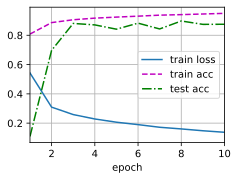

In [ ]:
%%time
lr, num_epochs, batch_size = 0.1, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

# Заключение
Мы познакомились лишь с некоторыми моделями нейронных сетей для классификации изображений. Число их велико. Некоторые стремятся повысить эффективность вычислений за счет использования разделимых сверток, как MobileNet.

Другие задачи обработки изображений часто используют предобученные части сетей для классификации, познакомимся с ними в следующий раз.

# Ссылки
Использованы и адаптированы материалы

https://d2l.ai/chapter_convolutional-modern/densenet.html